In [10]:
import matplotlib.pyplot as plt; plt.style.use("seaborn")
import numpy as np
from termcolor import colored

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

from tensorflow import keras 

# Binary classification recap

# Create Data Set
train_x -> normal<br>
train_x_noise -> normal + noise

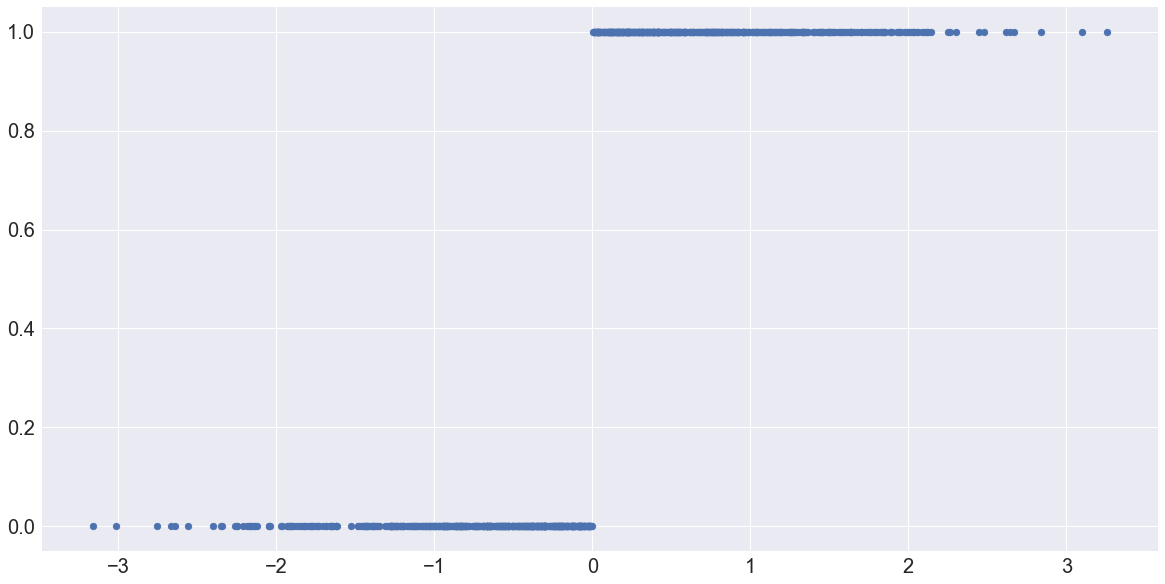

In [17]:
n_train, n_validation, n_test = 1000, 300, 300

train_x = np.random.normal(0, 1, size = (n_train, 1))
train_x_noise = train_x + 0.2*np.random.normal(0, 1, size = (n_train, 1))
train_y = (train_x_noise > 0).astype(np.int32)

validation_x = np.random.normal(0, 1, size = (n_validation, 1))
validation_x_noise = validation_x + 0.2*np.random.normal(0, 1, size = (n_validation, 1))
validation_y = (validation_x_noise > 0).astype(np.int32)

test_x = np.random.normal(0, 1, size = (n_test, 1))
test_x_noise = test_x + 0.2*np.random.normal(0, 1, size = (n_test, 1))
test_y = (test_x_noise > 0).astype(np.int32)


fig,ax = plt.subplots(figsize = (20, 10))
ax.scatter(train_x_noise, train_y)
ax.tick_params(labelsize = 20)

# Create Data Set

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(n_train).batch(8)

validation_ds = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))
validation_ds = validation_ds.shuffle(n_train).batch(n_validation)


test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.batch(n_test)

## Model: Both same

In [11]:
model = Sequential()
model.add(Dense(units = 2, activation = "softmax"))


class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = Dense(units = 2, activation = "softmax")
    def call(self, x):
        x = self.d1(x)
        return x

## loss, optimizer

In [8]:
loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate = 1)

코드가 길다

In [ ]:
train_loss = Mean()
train_acc = SparseCategoricalAccuracy()

validation_loss = Mean()
validation_acc = SparseCategoricalAccuracy()

test_loss = Mean()
test_acc = SparseCategoricalAccuracy()

train_losses, validation_losses = [], []
train_accs, validation_accs = [], []

EPOCHS = 10


for epoch in range(EPOCHS):
    for x, y, in train_ds:

        
        with tf.GradientTape() as tape:
            predictions = model(x) # 예측을 위해 model에 통과
            loss = loss_object(y, predictions)
            
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        train_loss(loss)
        train_acc(y, predictions)

    validation()  
    
    for x, y in validation_ds:
        predictions = model(x) # 예측을 위해 model에 통과
        loss = loss_object(y, predictions) 
    
        validation_loss(loss) # validation loss에 쌓임
        validation_acc(y, predictions)
        
        
    print(colored("Epoch: ", "red", "on_white"), epoch + 1)
    template = "Train Loss: {:.4f}\t Train Accuracy: {:.2f}% \n" +\
        "Validation Loss: {:.4f}\t Validation Accuracy: {:.2f}% \n"
    print(template.format(train_loss.result(), train_acc.result()*100,
                         validation_loss.result(), validation_acc.result()*100))
    
    train_losses.append(train_loss.result())
    validation_losses.append(validation_loss.result())
    train_accs.append(train_acc.result())
    validation_accs.append(validation_acc.result())
    
    
    train_loss.reset_states()
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()
    
    
for x,y in test_ds:
    predictions = model(x) # 예측을 위해 model에 통과
    loss = loss_object(y, predictions) 
    
    test_loss(loss) # validation loss에 쌓임
    test_acc(y, predictions)
    
print(colored("Final Result: ", "cyan", "on_white"), epoch + 1)
template = "Test Loss: {:.4f}\t Test Accuracy: {:.2f}%"
print(template.format(test_loss.result(), test_acc.result()*100))

함수를 만들어 사용하자 <br>
@tf.function는 속도 빨라짐

In [41]:
@tf.function
def train_step(x, y):
    global model, loss_object
    global train_loss, train_acc
    
    
    with tf.GradientTape() as tape:
        predictions = model(x) # 예측을 위해 model에 통과
        loss = loss_object(y, predictions)
            
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_acc(y, predictions)
    
    
@tf.function
def validation():
    global validation_ds, model, loss_object
    global validation_loss, validation_acc
    
    
    for x, y in validation_ds:
        predictions = model(x) # 예측을 위해 model에 통과
        loss = loss_object(y, predictions) 
    
        validation_loss(loss) # validation loss에 쌓임
        validation_acc(y, predictions)

def train_reporter():
    global epoch
    global train_loss, train_acc
    global validation_loss, validation_acc
    
    print(colored("Epoch: ", "red", "on_white"), epoch + 1)
    template = "Train Loss: {:.4f}\t Train Accuracy: {:.2f}% \n" +\
        "Validation Loss: {:.4f}\t Validation Accuracy: {:.2f}% \n"
    print(template.format(train_loss.result(), train_acc.result()*100,
                         validation_loss.result(), validation_acc.result()*100))
    
    
def metric_resetter():
    global train_loss, train_acc
    global validation_loss, validation_acc
    
    train_losses.append(train_loss.result())
    validation_losses.append(validation_loss.result())
    train_accs.append(train_acc.result()*100)
    validation_accs.append(validation_acc.result()*100)
    
    
    train_loss.reset_states()
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()
    
    
def fianl_result_visualization():
    global train_losses, train_accs
    global validation_losses, validation_accs
    
    fig, axes = plt.subplots(2, 1, figsize = (20,15))
    axes[0].plot(train_losses, 
                label = "Train Loss")
    axes[0].plot(validation_losses,
                label = "Validation Loss")
    axes[1].plot(train_accs,
                label = "Train Accuracy")
    axes[1].plot(validation_accs,
                label = "Validation Accuracy")
    
    axes[0].tick_params(labelsize = 20)
    axes[1].tick_params(labelsize = 20)
    
    axes[0].set_ylabel("Binary Cross Entropy", fontsize = 20)
    axes[1].set_ylabel("Accuracy", fontsize = 20)
    axes[1].set_xlabel("Epoch", fontsize = 20)
    
    axes[0].legend(loc = "lower right")
    axes[1].legend(loc = "upper right")     

Epoch:  1
Train Loss: 0.1393	 Train Accuracy: 94.00% 
Validation Loss: 0.1287	 Validation Accuracy: 94.33% 

Epoch:  2
Train Loss: 0.1417	 Train Accuracy: 94.60% 
Validation Loss: 0.1291	 Validation Accuracy: 94.33% 

Epoch:  3
Train Loss: 0.1395	 Train Accuracy: 94.00% 
Validation Loss: 0.1288	 Validation Accuracy: 94.33% 

Epoch:  4
Train Loss: 0.1391	 Train Accuracy: 93.50% 
Validation Loss: 0.1301	 Validation Accuracy: 94.33% 

Epoch:  5
Train Loss: 0.1406	 Train Accuracy: 94.00% 
Validation Loss: 0.1294	 Validation Accuracy: 94.67% 

Epoch:  6
Train Loss: 0.1382	 Train Accuracy: 94.10% 
Validation Loss: 0.1344	 Validation Accuracy: 95.67% 

Epoch:  7
Train Loss: 0.1393	 Train Accuracy: 93.90% 
Validation Loss: 0.1338	 Validation Accuracy: 94.00% 

Epoch:  8
Train Loss: 0.1374	 Train Accuracy: 94.30% 
Validation Loss: 0.1363	 Validation Accuracy: 95.00% 

Epoch:  9
Train Loss: 0.1417	 Train Accuracy: 93.80% 
Validation Loss: 0.1284	 Validation Accuracy: 94.67% 

Epoch:  10
Train Lo

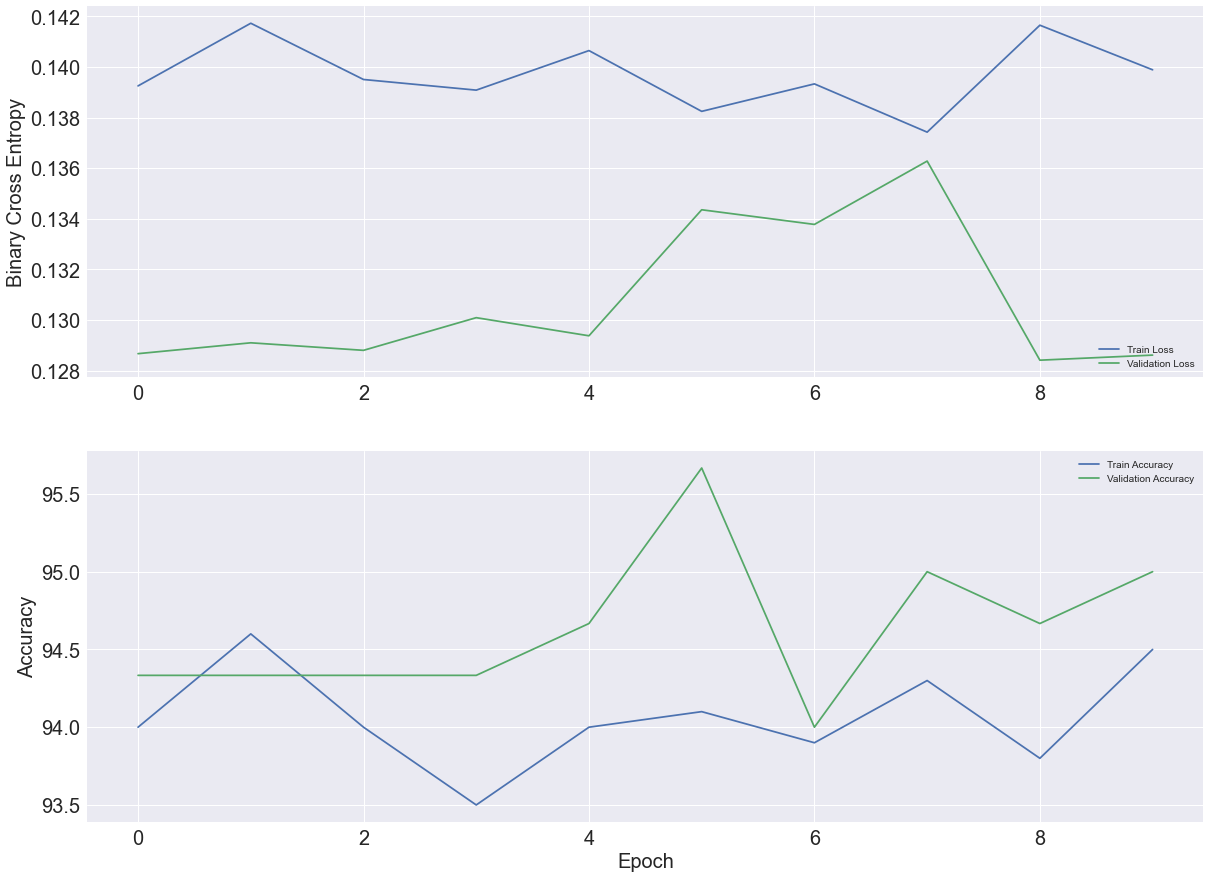

In [42]:
train_loss = Mean()
train_acc = SparseCategoricalAccuracy()

validation_loss = Mean()
validation_acc = SparseCategoricalAccuracy()

test_loss = Mean()
test_acc = SparseCategoricalAccuracy()

train_losses, validation_losses = [], []
train_accs, validation_accs = [], []

EPOCHS = 10


for epoch in range(EPOCHS):
    for x, y, in train_ds:
        train_step(x, y)

    validation()  
    train_reporter()
    metric_resetter()
    
      
for x,y in test_ds:
    predictions = model(x) # 예측을 위해 model에 통과
    loss = loss_object(y, predictions) 
    
    test_loss(loss) # validation loss에 쌓임
    test_acc(y, predictions)
    
    
fianl_result_visualization()
print(colored("Final Result: ", "cyan", "on_white"), epoch + 1)
template = "Test Loss: {:.4f}\t Test Accuracy: {:.2f}%"
print(template.format(test_loss.result(), test_acc.result()*100))

# Epoch에 대하여
Epoch을 돌릴 때 epoch마다 loss가 개별적으로 간주되어야 한다<br>
원하는 결과: 두 번째 for loop에서 tf.Tensor(1.0, shape=(), dtype=float32)로 시작<br>
실제: train_loss = Mean()이 첫 for loop에 대하여 실행 완료한 후 그 상태로 두번째 for loop로 들어감

In [14]:
train_loss = Mean()

t1 = tf.constant([1, 2, 3, 4, 5, 6])
for t in t1:
    train_loss(t)
    print(train_loss.result())

print("\n")  

t2 = tf.constant([1, 2, 3, 4, 5, 6])
for t in t2:
    train_loss(t)
    print(train_loss.result())

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)


tf.Tensor(3.142857, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(3.1, shape=(), dtype=float32)
tf.Tensor(3.2727273, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)


해결 방안: reset_states()

In [15]:
train_loss = Mean()

t1 = tf.constant([1, 2, 3, 4, 5, 6])
for t in t1:
    train_loss(t)
    print(train_loss.result())

print("\n")  

train_loss.reset_states()

t2 = tf.constant([1, 2, 3, 4, 5, 6])
for t in t2:
    train_loss(t)
    print(train_loss.result())

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)


tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(3.5, shape=(), dtype=float32)
